# Installing Dependencies

In [36]:
pip -q install ruptures scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at e:\swe\python3.11.5\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [72]:
import os
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import ruptures as rpt

from tqdm import tqdm
tqdm.pandas()

# Data Loading

In [38]:
dataset = 'DF'

In [39]:
rightEDAdatapath  = f'{dataset}/EDA.csv'
rightHRdatapath   = f'{dataset}/HR.csv'
rightTEMPdatapath = f'{dataset}/TEMP.csv'

### HR Data Processing

- HR data relatively less than EDA and TEMP so data is repeated 4 times to have similar amount of data as the other readings

In [40]:
rightHRdatapath = np.loadtxt(rightHRdatapath, delimiter = ',')
rightHRdatapath = np.repeat(rightHRdatapath, 4)
np.savetxt('hr_new.csv', rightHRdatapath, delimiter = ',')

### Loading Details

- EDA: ignoring the first 2 rows for EDA since 1st row indicates start time of session and 2nd row indicates sample rate in Hz
- HR: ignores the first 12 rows since heart rate stabilizes after a few readings
- TEMP: ignores first 2 rows for the same reason as EDA

In [41]:
edat =  pd.read_csv(f'{dataset}/EDA.csv',  header = 2,  names = ['EDA'])
hrt =   pd.read_csv(f'hr_new.csv',      header = 12, names = ['HR'])
tempt = pd.read_csv(f'{dataset}/TEMP.csv', header = 2,  names = ['TEMP'])

In [42]:
# contains the session time, no data
gt =    pd.read_csv(f'{dataset}/EDA.csv',  nrows  = 1)

In [43]:
print(len(edat), len(hrt), len(tempt), len(gt))

22979 22935 22979 1


### Label Loading

In [44]:
label = pd.read_csv(f'{dataset}/SM_Drv13.csv',  header = 1,  names = ['STRESS'])
label = label.iloc[20:]

# Resetting the index after removing rows
label.reset_index(drop=True, inplace=True)

In [45]:
print(len(label))

22944


In [46]:
reference_time = gt.iloc[0,0]

In [47]:
min_len = min(len(edat), len(hrt), len(tempt), len(label))

# first min_len rows of the column '0' taken from each data frame
eda = edat.iloc[:min_len, 0]
hrt = hrt.iloc[:min_len, 0]
tempt = tempt.iloc[:min_len, 0]
label = label.iloc[:min_len, 0]

# all data combined column wise to make another data frame
df_original = pd.concat([eda, hrt, tempt, label], axis = 1)

In [48]:
print(df_original.shape)

(22935, 4)


## Pre-processing

### Feature Extraction

In [49]:
def statistical_features(arr):
    vmin = np.amin(arr)
    vmax = np.amax(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return vmin, vmax, mean, std

def shape_features(arr):
    skewness = skew(arr)
    kurt = kurtosis(arr)
    return skewness, kurt

def calculate_rms(signal):
    diff_squared = np.square(np.ediff1d(signal))
    rms_value = np.sqrt(np.mean(diff_squared))
    return rms_value

### Extended Features

- iterating with a step size of 20
- taking 40 rows at a time to generate a single row of df_features
- find_peaks() : identify peaks in the EDA signal (eda) using the function and then count the number of detected peaks using len() function

In [52]:
def extract_features(data):
    cols = [
        'EDA_Mean', 'EDA_Min', 'EDA_Max', 'EDA_Std', 'EDA_Kurtosis', 'EDA_Skew', 'EDA_Num_Peaks', 'EDA_Amplitude', 'EDA_Duration',
        'HR_Mean', 'HR_Min', 'HR_Max', 'HR_Std', 'HR_RMS', 'TEMP_Mean', 'TEMP_Min', 'TEMP_Max', 'TEMP_Std', 'STRESS'
    ]

    df_features = pd.DataFrame(columns=cols)
    index = 0

    for i in tqdm(range(0, len(data['EDA']), 20), desc="Processing rows", leave=True):
        df_partial = data.iloc[i:i+40,]
        plen = len(df_partial['EDA'])

        if plen < 40:
            continue

        eda = df_partial['EDA'].values
        hr = df_partial['HR'].values
        temp = df_partial['TEMP'].values
        stress = df_partial['STRESS'].values

        eda_min, eda_max, eda_mean, eda_std = statistical_features(eda)
        hr_min, hr_max, hr_mean, hr_std = statistical_features(hr)
        temp_min, temp_max, temp_mean, temp_std = statistical_features(temp)
        stress_min, stress_max, stress_mean, stress_std = statistical_features(stress)
        eda_skew, eda_kurtosis = shape_features(eda)

        hr_rms = calculate_rms(hr)
        temp_rms = calculate_rms(temp)

        peaks, properties = find_peaks(eda, width=5)
        num_Peaks = len(peaks)

        prominences = np.array(properties['prominences'])
        widths = np.array(properties['widths'])
        amplitude = np.sum(prominences)
        duration = np.sum(widths)

        df_features.loc[index] = [eda_mean, eda_min, eda_max, eda_std, eda_kurtosis, eda_skew, num_Peaks, amplitude,
                                  duration, hr_mean, hr_min, hr_max, hr_std, hr_rms, temp_mean, temp_min, temp_max, temp_std, stress_mean]

        index = index + 1

    return df_features

In [53]:
df_features = extract_features(df_original)

Processing rows: 100%|██████████| 1147/1147 [00:02<00:00, 417.64it/s]


In [54]:
print(df_features.columns)

Index(['EDA_Mean', 'EDA_Min', 'EDA_Max', 'EDA_Std', 'EDA_Kurtosis', 'EDA_Skew',
       'EDA_Num_Peaks', 'EDA_Amplitude', 'EDA_Duration', 'HR_Mean', 'HR_Min',
       'HR_Max', 'HR_Std', 'HR_RMS', 'TEMP_Mean', 'TEMP_Min', 'TEMP_Max',
       'TEMP_Std', 'STRESS'],
      dtype='object')


In [55]:
print(df_features.shape)

(1145, 19)


### Lag Features

In [56]:
def generate_lag_features(input_df, columns, lags):
    cols = list(map(str, range(len(columns) * len(lags), 0, -1)))
    lag_df = pd.DataFrame(columns=cols)

    index = len(columns) * len(lags)

    for col in tqdm(columns, desc="Generating lag features", leave=True):
        for lag in tqdm(lags, desc=f"Lag features for {col}", leave=True):
            lagged_column = f'{index}'
            lag_df[lagged_column] = input_df[col].shift(lag)
            index -= 1

    # lag_df = lag_df.dropna()

    return lag_df

In [57]:
cols = ['HR_Mean', 'TEMP_Mean', 'EDA_Mean']
lags = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

df_lag_features = generate_lag_features(df_features, cols, lags)

Generating lag features: 100%|██████████| 3/3 [00:00<00:00, 54.16it/s]


In [58]:
print(df_lag_features.shape)

(1145, 30)


In [59]:
df_total = pd.concat([df_lag_features, df_features], axis=1)

In [60]:
print(df_total.shape)

(1145, 49)


### Feature and Label Scaling

In [61]:
def scale_features(df_total, feature_columns):
    scaled_df = df_total.copy()
    scaler = MinMaxScaler()
    scaled_df[feature_columns] = scaler.fit_transform(scaled_df[feature_columns])
    scaled_df = scaled_df.fillna(0)
    return scaled_df

In [66]:
def scale_label(df_total, label_column, target_range=(0, 10)):
    label_to_scale = df_total[label_column].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=target_range)
    scaled_label = scaler.fit_transform(label_to_scale)
    df_total[label_column] = scaled_label.flatten()
    return df_total

In [68]:
feature_cols = df_total.columns[:48]
df_total_scaled = scale_features(df_total, feature_cols)
df_total_scaled = scale_label(df_total_scaled, 'STRESS', target_range=(0, 10))

Final CSV File for Training

In [69]:
df_total_scaled.to_csv('scaled_df_total.csv', index=False)

# Stress detection model

In [80]:
df_lag = pd.read_csv('scaled_df_total.csv')
print(df_lag.shape)
train_set = df_lag.iloc[:,0:48]
labels = df_lag.iloc[:,48:49]

#Create a random forest Classifier
clf = RandomForestRegressor(n_estimators=100,max_depth=15)

# Split our data
train, test, train_labels, test_labels = train_test_split(train_set, labels, test_size=0.33, random_state=30)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train, train_labels.values.ravel())



y_pred = clf.predict(test)

threshold = 0.5  # Define your tolerance level

# Count the number of predictions within the tolerance
correct_predictions = np.sum(np.abs(test_labels.values.ravel() - y_pred) <= threshold)

# Calculate the accuracy-like metric
accuracy_like_metric = correct_predictions / len(test_labels)

print('Accuracy-like Metric:', accuracy_like_metric)

# f1score   = f1_score        (test_labels, y_pred, average = 'macro')
# recall    = recall_score    (test_labels, y_pred, average = 'macro')
# precision = precision_score (test_labels, y_pred, average = 'macro')
# accuracy  = accuracy_score  (test_labels, y_pred)

# print('acc =', accuracy)
# print('pre =', precision)
# print('recall =', recall) 
# print('f1 =', f1score)

(1145, 49)
Accuracy-like Metric: 0.291005291005291


### Predicting the stress

In [28]:
df_total = df_total.dropna()
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(df_total.iloc[:,0:48])
data = pd.DataFrame(x_scaled)
data = data.fillna(0)

pred_t = clf.predict(data)
pred_t = pd.DataFrame(pred_t)
pred_t.columns=['pred']
pred_t.head(30)
pred_t.to_csv('pred'+user+'.csv')

C:\Users\Maria\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


NameError: name 'user' is not defined

In [ ]:
df_total['pred'] = pred_t
df_total.to_csv('pred{user}.csv')

In [ ]:
df_total['MA_3'] = np.ceil(df_total.iloc[:,48:49].rolling(window=31).mean())

### Change detection

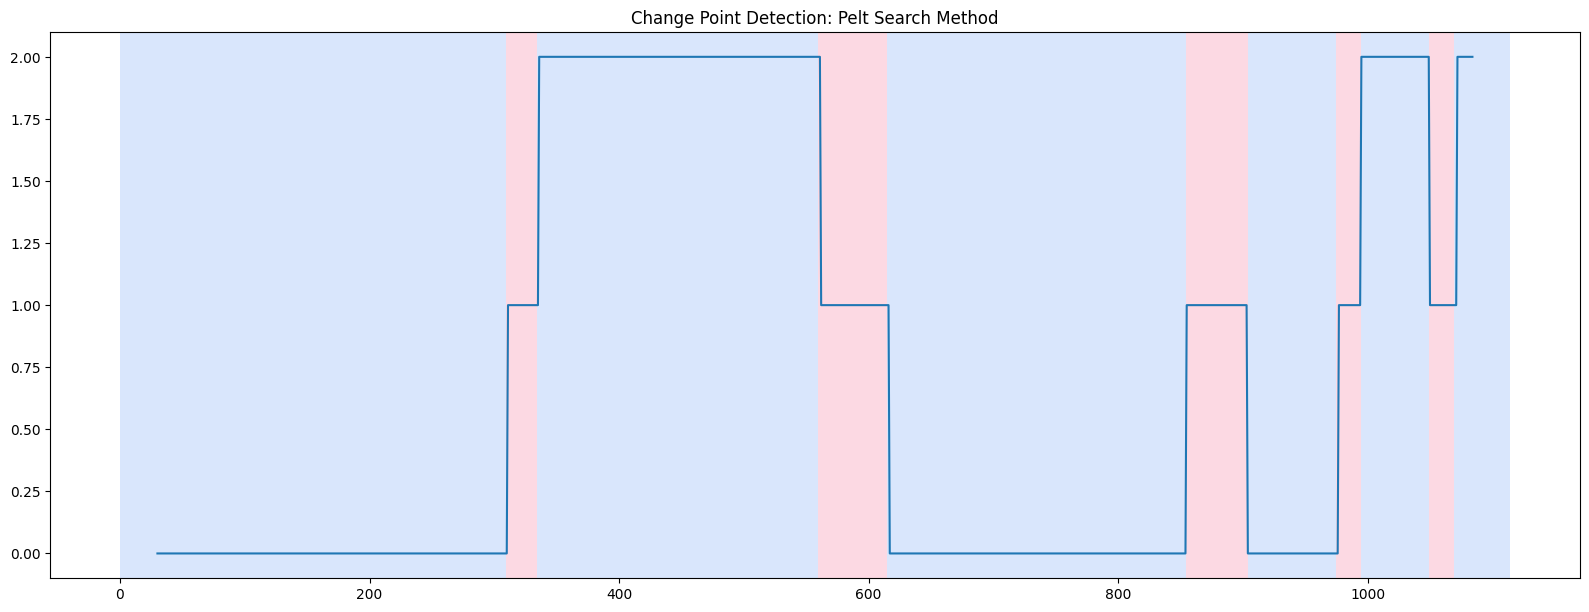

[0, 310, 335, 560, 615, 855, 905, 975, 995, 1050, 1070, 1115]


In [ ]:
signal = df_total.iloc[:,49:50].values

algo = rpt.Window(model="l2", width=10).fit(signal)
result = algo.predict(n_bkps=60)

rpt.display(signal, result, figsize=(16, 6))
plt.title('Change Point Detection: Pelt Search Method')
plt.show()

result.insert(0, 0)
print(result)

### Generating the event by start and end epoch_times

In [ ]:
temp_start = 0
temp_end = result[0]

stress = []
for i in range (len(result)-1):
    
    temp = df_total.iloc[result[i]:(result[i+1]-1), 49:50].mean()[0]
    
    if temp > 1.3:
        temp = 2.0
    elif temp >= .65:
        temp = 1
    else:
        temp = 0

    stress.append(temp)
    
df_temp = pd.DataFrame(columns=['start', 'end', 'stress'])
c = 0
for i in range(len(result)-1):
    stressLength = (result[i+1] - result[i]) / 12

    start_point  = result[i]
    end_point    = result[i + 1]
    stress_value = stress[i]
    
    if temp_end <= start_point:
        temp_end       = end_point
        df_temp.loc[c] = [start_point, end_point, stress_value]
        c = c +1

df_temp

C:\Users\Maria\AppData\Local\Temp\ipykernel_13080\2647975276.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = df_total.iloc[result[i]:(result[i+1]-1), 49:50].mean()[0]


,start,end,stress
0,0.0,310.0,0.0
1,310.0,335.0,1.0
2,335.0,560.0,2.0
3,560.0,615.0,1.0
4,615.0,855.0,0.0
5,855.0,905.0,1.0
6,905.0,975.0,0.0
7,975.0,995.0,1.0
8,995.0,1050.0,2.0
9,1050.0,1070.0,1.0


## Change event time to datetime

In [ ]:
stress_start = 0
stress_end = 0
tse = 0
previous_stress = -1

for index, row in df_temp.iterrows():

    if row['stress'] == previous_stress:
        stress_end = row['end']
    else:
        if(previous_stress != -1):
            start    = datetime.fromtimestamp(reference_time + (stress_start * 5))
            end      = datetime.fromtimestamp(reference_time + (stress_end * 5))
            timediff = end - start
            print('Prev:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)
        
        stress_start    = row['start']
        stress_end      = row['end']
        previous_stress = row['stress']
        
print('Final:', timediff, datetime.fromtimestamp(reference_time + (stress_start * 5)).strftime('%H:%M:%S'), datetime.fromtimestamp(reference_time + (stress_end * 5)).strftime('%H:%M:%S'), previous_stress)

Prev: 0:25:50 06:00:04 06:25:54 0.0
Prev: 0:02:05 06:25:54 06:27:59 1.0
Prev: 0:18:45 06:27:59 06:46:44 2.0
Prev: 0:04:35 06:46:44 06:51:19 1.0
Prev: 0:20:00 06:51:19 07:11:19 0.0
Prev: 0:04:10 07:11:19 07:15:29 1.0
Prev: 0:05:50 07:15:29 07:21:19 0.0
Prev: 0:01:40 07:21:19 07:22:59 1.0
Prev: 0:04:35 07:22:59 07:27:34 2.0
Prev: 0:01:40 07:27:34 07:29:14 1.0
Final: 0:01:40 07:29:14 07:32:59 2.0
